Use the Dataset Link: https://www.kaggle.com/datasets/hm-land-registry/uk-housingprices-paid and filter it for a smaller time range (e.g., last 2 years) and select columns like:

• price

• property_type

• town_city

• postcode

• date_of_transfer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

In [5]:
file_path = '/content/drive/My Drive/Colab Notebooks/price_paid_records.csv'


Q1. Decision Tree Classification in RAPIDS

In [6]:
import pandas as pd
from datetime import datetime, timedelta


In [7]:
file_path = "/content/drive/MyDrive/Colab Notebooks/price_paid_records.csv"
cutoff_date = datetime.now() - timedelta(days=730)


In [8]:
df_check = pd.read_csv(file_path, nrows=5)
print("Column names in your file:", df_check.columns.tolist())


Column names in your file: ['Transaction unique identifier', 'Price', 'Date of Transfer', 'Property Type', 'Old/New', 'Duration', 'Town/City', 'District', 'County', 'PPDCategory Type', 'Record Status - monthly file only']


In [9]:
import pandas as pd


In [10]:
file_path = "/content/drive/My Drive/Colab Notebooks/price_paid_records.csv"
cutoff_date = pd.Timestamp("2016-01-01")

In [11]:
chunks = pd.read_csv(
    file_path,
    usecols=['Price', 'Property Type', 'Town/City', 'Date of Transfer'],
    parse_dates=['Date of Transfer'],
    chunksize=100_000,
    low_memory=False
)

In [12]:
filtered_chunks = []
for chunk in chunks:
    chunk = chunk[chunk['Date of Transfer'] >= cutoff_date]
    filtered_chunks.append(chunk)


In [13]:
df_selected = pd.concat(filtered_chunks)
print("✅ Filtered dataset shape:", df_selected.shape)
print(df_selected.head())


✅ Filtered dataset shape: (1407656, 4)
            Price Date of Transfer Property Type Town/City
21081692  1860000       2016-03-21             F    LONDON
21081693   385000       2016-04-15             F    LONDON
21081694   540000       2016-04-21             F    LONDON
21081695  2300000       2016-03-31             T    LONDON
21081696  2650000       2016-03-31             F    LONDON


In [14]:
df_dates = pd.read_csv(file_path, usecols=['Date of Transfer'], parse_dates=['Date of Transfer'])
print("📅 Min date:", df_dates['Date of Transfer'].min())
print("📅 Max date:", df_dates['Date of Transfer'].max())


📅 Min date: 1995-01-01 00:00:00
📅 Max date: 2017-06-29 00:00:00


In [1]:
import cudf


In [15]:
gdf = cudf.DataFrame.from_pandas(df_selected)


In [16]:
import cudf


In [17]:
gdf = cudf.DataFrame.from_pandas(df_selected)


In [18]:
median_price = gdf['Price'].median()
gdf['target'] = (gdf['Price'] >= median_price).astype('int32')


In [19]:
from cuml.preprocessing import LabelEncoder

cat_cols = ['Property Type', 'Town/City']
for col in cat_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])


In [20]:
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
import time


In [23]:
features = ['Property Type', 'Town/City']
X = gdf[features]
y = gdf['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [25]:
start_gpu = time.time()
clf_gpu = RandomForestClassifier(n_estimators=100, max_depth=5)
clf_gpu.fit(X_train, y_train)
gpu_time = time.time() - start_gpu

print(f" GPU Random Forest trained in {gpu_time:.4f} seconds")


 GPU Random Forest trained in 4.0219 seconds


In [26]:
from cuml.metrics import accuracy_score
from sklearn.metrics import precision_score, confusion_matrix


In [27]:
y_pred = clf_gpu.predict(X_test)


In [28]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test.to_pandas(), y_pred.to_pandas())
cm = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())



In [29]:
print("🎯 Accuracy:", acc)
print("🎯 Precision:", prec)
print("📊 Confusion Matrix:\n", cm)


🎯 Accuracy: 0.5876795053482056
🎯 Precision: 0.6781617364852379
📊 Confusion Matrix:
 [[117742  22641]
 [ 93440  47708]]


In [30]:
from sklearn.ensemble import RandomForestClassifier as SkRF
from sklearn.model_selection import train_test_split as sk_split


In [31]:
pdf = gdf.to_pandas()
X = pdf[features]
y = pdf['target']
X_train, X_test, y_train, y_test = sk_split(X, y, test_size=0.2)


In [32]:
start_cpu = time.time()
clf_cpu = SkRF(n_estimators=100, max_depth=5)
clf_cpu.fit(X_train, y_train)
cpu_time = time.time() - start_cpu


In [33]:
print(f" CPU RF trained in {cpu_time:.4f} seconds")
print(f" GPU RF trained in {gpu_time:.4f} seconds")


 CPU RF trained in 62.9711 seconds
 GPU RF trained in 4.0219 seconds


Q2: Random Forest Classification in RAPIDS

In [34]:
features = ['Property Type', 'Town/City']
X = gdf[features]
y = gdf['target']

In [35]:
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
import time


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [37]:
start = time.time()
rf_gpu = RandomForestClassifier(n_estimators=100, max_depth=5)
rf_gpu.fit(X_train, y_train)
gpu_time = time.time() - start

print(f"✅ Trained Random Forest with 100 trees in {gpu_time:.4f} seconds")


✅ Trained Random Forest with 100 trees in 2.6818 seconds


In [38]:
import matplotlib.pyplot as plt
from cuml.metrics import accuracy_score


In [39]:
tree_counts = [10, 25, 50, 75, 100, 150]
accuracies = []


In [40]:
for n in tree_counts:
    model = RandomForestClassifier(n_estimators=n, max_depth=5)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)


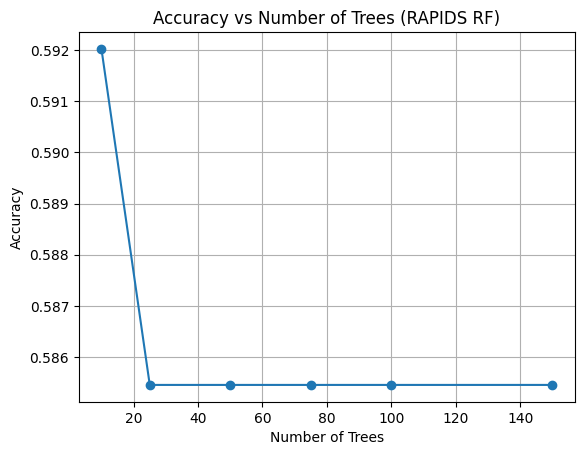

In [41]:
plt.plot(tree_counts, accuracies, marker='o')
plt.title("Accuracy vs Number of Trees (RAPIDS RF)")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [42]:
train_accuracies = []
test_accuracies = []


In [43]:
for n in tree_counts:
    model = RandomForestClassifier(n_estimators=n, max_depth=10)
    model.fit(X_train, y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))

    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)


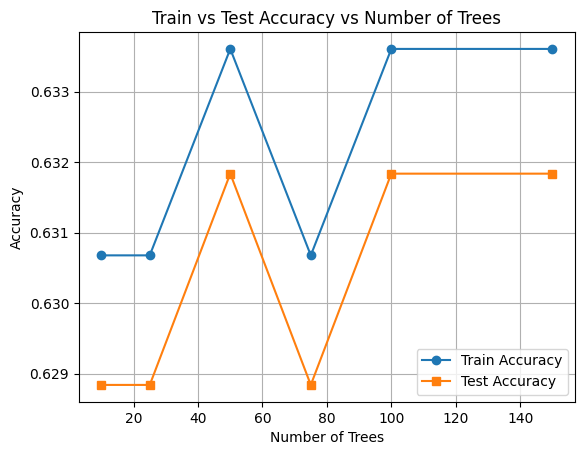

In [44]:
plt.plot(tree_counts, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(tree_counts, test_accuracies, label='Test Accuracy', marker='s')
plt.title("Train vs Test Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Q3: KMeans Clustering using RAPIDS

In [45]:
from cuml.preprocessing import LabelEncoder
import cudf


In [46]:
gdf = cudf.DataFrame.from_pandas(df_selected)


In [47]:
cat_cols = ['Property Type', 'Town/City']
for col in cat_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])


In [48]:
features = ['Price', 'Property Type', 'Town/City']
X = gdf[features]


In [49]:
from cuml.cluster import KMeans


In [50]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)
labels_3 = kmeans_3.labels_


In [51]:
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(X)
labels_5 = kmeans_5.labels_


In [58]:
X_pdf = X.to_pandas()
labels_np = labels_3.values_host

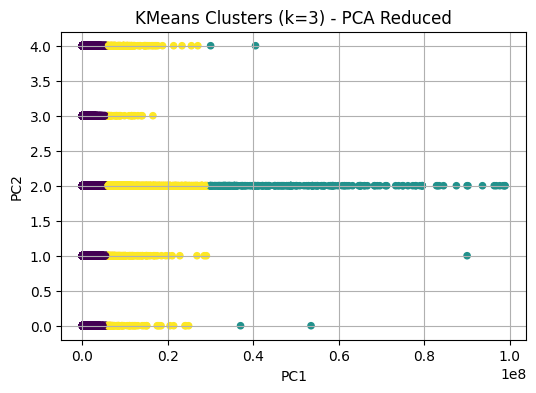

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(X_pdf.iloc[:, 0], X_pdf.iloc[:, 1], c=labels_np, cmap='viridis', s=20)
plt.title("KMeans Clusters (k=3) - PCA Reduced")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [67]:
sample_indices = X_cpu.sample(n=10000, random_state=42).index

X_sample = X_cpu.loc[sample_indices]
labels_sample = pd.Series(labels_3_cpu, index=X_cpu.index).loc[sample_indices]

from sklearn.metrics import silhouette_score
silhouette_sample = silhouette_score(X_sample, labels_sample)

print("Sampled Silhouette Score (k=3):", silhouette_sample)


NameError: name 'X_cpu' is not defined

Q4: Dimensionality Reduction and Visualization

In [68]:
from cuml.decomposition import PCA

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

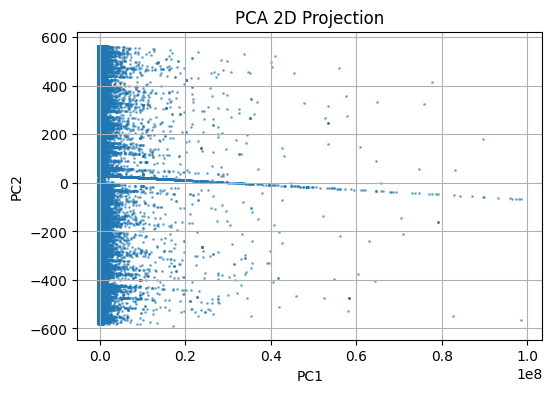

In [69]:
import matplotlib.pyplot as plt

X_pca_2d_pdf = X_pca_2d.to_pandas()

plt.figure(figsize=(6, 4))
plt.scatter(X_pca_2d_pdf.iloc[:, 0], X_pca_2d_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

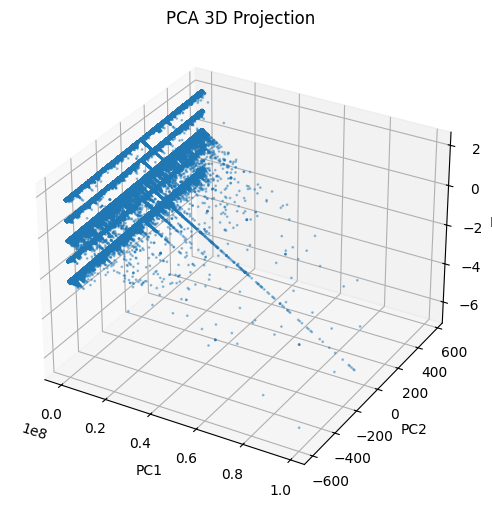

In [70]:
from mpl_toolkits.mplot3d import Axes3D

X_pca_3d_pdf = X_pca_3d.to_pandas()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d_pdf.iloc[:, 0], X_pca_3d_pdf.iloc[:, 1], X_pca_3d_pdf.iloc[:, 2], s=1, alpha=0.4)
ax.set_title("PCA 3D Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [ ]:
from cuml.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

X_tsne_pdf = X_tsne.to_pandas()
plt.scatter(X_tsne_pdf.iloc[:, 0], X_tsne_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("t-SNE Projection (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [ ]:
from cuml.manifold import UMAP

umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap.fit_transform(X)

X_umap_pdf = X_umap.to_pandas()
plt.scatter(X_umap_pdf.iloc[:, 0], X_umap_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("UMAP Projection (2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()
